# README
以下，README.mdを表示

In [ ]:
import codecs
from IPython.display import display, Markdown
with codecs.open('readme.md', 'r', 'utf-8') as fh:
    content = fh.read()
display(Markdown(content))

# 設定ファイル作成用スクリプト

設定ファイル（`InitCmaes.txt`および`InitProblem.txt`）を編集するツール．
設定ファイルを直接変更してもよいが，
* 次元数に依存して変更する必要のある初期値（初期平均ベクトルや初期ステップサイズなど）
* 乱数を用いて変更したい初期値（初期平均ベクトルなど）

を設定する際には，以下を利用すると便利．

#### 設定をPythonの辞書に格納．各設定の詳細は README.mdを参照

In [ ]:
from time import gmtime, strftime
import numpy as np

以下，必要な箇所を修正する

In [ ]:
N = 10  # 次元数．最適化する変数の数
setting = dict()
setting['flg_minimization'] = True  # True: 最小化，False: 最大化
setting['flg_restart'] = False       # True: 最大評価回数か最大イテレーション数に引っかかるまでリスタート，False: リスタート無し
setting['flg_resume'] = False       # True: セーブされた途中経過からスタート，False: 新規スタート
setting['flg_save'] = True          # True: 途中の状態をセーブ，False: セーブしない．
setting['flg_visualizatione'] = True  # True: 可視化スクリプト用のデータを出力，False: 出力なし
setting['dim'] = N                  # int : 次元数
setting['initpopsize'] = 4 + int(3 * np.log(N)) # int : 初期集団サイズ．リスタート毎に二倍される
setting['maxpopsize'] = setting['initpopsize']  # int : 最大集団サイズ．到達後はこの値を集団サイズとしてリスタート
setting['print_span'] = 1           # int : 結果表示のスパン．1ならば毎イテレーション表示
setting['flag_diagonal'] = 1        # 0: 通常のCMA，1: Separable-CMA（対角行列を用いたCMA，変数間依存の少ない問題や高次元問題で効果的）
setting['flag_active'] = 1          # 0: 通常のCMA，1: Active-CMA（負の重みを活用したCMA）
setting['maxeval'] = int(1e5) * N   # int : 最大評価回数
setting['maxiter'] = int(1e5)       # int : 最大イテレーション数
setting['seed'] = int(strftime("%Y%H%M%S", gmtime())) # int : 擬似乱数のシード
setting['ftarget'] = 1e-5           # float : ターゲット目的関数値
setting['tolx'] = 1e-10             # float : 探索空間上での許容誤差．座標毎の標準偏差がこれよりも小さくなると終了
setting['tolf'] = 1e-10             # float : 目的関数値の許容誤差．目的関数値の標準偏差がこれよりも小さくなると終了
setting['sigma_correction_factor'] = 1.0 # float : 混合整数計画問題における，ステップサイズ修正係数．デフォルトは1，修正しない場合0．
setting['lb'] = [-5.0] * N          # list of float : 各変数の下限．下限がない場合には [-np.inf] * N とする
setting['ub'] = [5.0] * N           # list of float : 各変数の上限．上限がない場合には [np.inf] * N とする
setting['init_mean'] = (np.asarray(setting['ub']) + np.asarray(setting['lb'])) / 2.0  # list of float : 初期平均ベクトル
setting['init_std'] = (np.asarray(setting['ub']) - np.asarray(setting['lb'])) / 6.0   # list of float : 各変数の初期標準偏差
setting['stairwidth'] = [1.0] * (N//2) + [0.0] * (N//2)    # list of float : 混合整数計画問題の場合の刻み幅．連続変数なら [0] * N とする．

#### 設定を指定したファイル名（デフォルトは"InitCmaes.txt"）で出力する．
以下は編集しないこと．

In [ ]:
boolvals = ['flg_minimization', 'flg_restart', 'flg_resume', 'flg_save', 'flg_visualizatione']
intvals = ['dim', 'initpopsize', 'maxpopsize', 'print_span', 'flag_diagonal', 'flag_active', 'maxeval', 'maxiter', 'seed']
floatvals = ['ftarget', 'tolx', 'tolf', 'sigma_correction_factor']
arrayvals = ['lb', 'ub', 'init_mean', 'init_std', 'stairwidth']
with open('InitCmaes.txt', 'w') as f:
    for key in boolvals:
        f.write("{:>25}".format(key) + ' ' + ('T' if setting[key] else 'F'))
        f.write('\n')
    for key in intvals:
        f.write("{:>25}".format(key) + ' ' + repr(int(setting[key])))
        f.write('\n')
    for key in floatvals:
        f.write("{:>25}".format(key) + ' ' + repr(float(setting[key])))
        f.write('\n')
    for key in arrayvals:
        f.write("{:>25}".format(key) + ' ' + ' '.join([repr(float(x)) for x in setting[key]]))
        f.write('\n')

#### 問題用設定ファイル
ベンチマーク関数用の設定ファイル．
以下，探索空間の変換行列を定義
* `matI`: 単位行列（変換なし）
* `matD`: 対角行列（変数毎のスケール変換，悪スケール性）
* `matO`: 直交行列（回転変換，変数間依存性）
* `matODOt`: 回転変換とスケール変換（悪スケールかつ変数間依存）

In [ ]:
def gram_schmidt(mat):
    """Return a matrix whose row is orthonormalized"""
    R = mat.copy()
    for i in range(R.shape[0]):
        for j in range(i):
            R[i] = R[i] - np.dot(R[i], R[j]) * R[j]
        R[i] /= np.linalg.norm(R[i])
    return R

matI = np.eye(N)
matD = np.diag(np.logspace(0, 3, num=N, endpoint=True, base=1e1))
matO = gram_schmidt(np.random.randn(N, N))
matODOt = np.dot(matO.T * matD, matO)

以下を編集する．

* `stairwidth`: 各変数のステップ幅（混合整数計画問題の場合）連続最適化の場合には `np.zeros(N)` とする．
* `matR`: 探索空間の変換行列を指定．変換しないならば，`matR = matI`とする．

In [ ]:
stairwidth = [1.0] * (N//2) + [0.0] * (N//2) #np.zeros(N)
matR = matI

設定ファイルを`InitProblem.txt`に書き出す．以下は編集しないこと．

In [ ]:
with open('InitProblem.txt', 'w') as f:
    f.write("{:>25} {}\n".format('dim', repr(N)))    # 次元数
    f.write("{:>25} {}\n".format('funcid', repr(2))) # 0: Sphere，1: Ellipsoid，2: Rosenbrock-Chain，3: Rastrigin
    f.write("{:>25}".format('stairwidth') + ' ' + ' '.join([repr(float(x)) for x in stairwidth]))
    f.write('\n')
    f.write("{:>25}".format('matR') + ' ' + ' '.join([repr(float(x)) for x in matR.flatten(order='F')]))
    f.write('\n')

# 実行スクリプト
プログラム確認用．通常はコマンドラインから実行すれば良い．

#### 設定ファイルの確認

In [ ]:
from __future__ import print_function
cmainit = 'InitCmaes.txt'
probinit = 'InitProblem.txt'
print(cmainit)
with open(cmainit, 'r') as f:
    for line in f:
        print(line, end='')
print(probinit)        
with open(probinit, 'r') as f:
    for line in f:
        print(line, end='')

#### コンパイル

In [ ]:
!sh compile.sh clear
#!sh compile.sh
!sh compile.sh lapack

#### 実行

In [ ]:
# SEP-CMA-ESでSegmentation fault
!./main.out InitCmaes.txt InitProblem.txt

# 作図用スクリプト
実行が正しくなされれば，出力ファイル"OutputCmaes.txt"が生成される．以下を実行することで，この結果が作図され，"OutputCmaes.png"および"OutputCmaes.pdf"が生成される．

### 横軸
イテレーション．各イテレーションでpopsize回目的関数を評価している．

### 左上図
* arffeas : 各イテレーションで得られた目的関数評価値の最小値
* arf     : 各イテレーションで得られた適応度（目的関数＋ペナルティ）の最小値

### 中上図
* arffeas-min(arffeas) : 各イテレーションで得られた目的関数評価値の最小値から，探索中に得られた最良のarffeasを引いた値．Logスケール．
* arf-min(arffeas)     : 各イテレーションで得られた適応度（目的関数＋ペナルティ）の最小値から，探索中に得られた最良のarffeasを引いた値．Logスケール．

### 右上図
* df      : 評価値の広がり．tolf以下になると打ち切り
* dx      : 変数の広がり．tolx以下になると打ち切り
* sigma   : CMA-ESのステップサイズ

### 左下図 
共分散行列の各固有値の平方根．密度の等高線（楕円）の軸の半径

### 中下図
平均ベクトルの各座標

### 右下図
共分散行列の各対角成分の平方根．座標ごとの標準偏差

### 図から読み取れること
* 共分散行列の各固有値の平方根のグラフと各対角成分の平方根のグラフが類似している場合，目的関数はおおよそ変数分離可能（変数間依存性が弱い）と推測される．
* 一般に，共分散行列は目的関数のヘッセ行列（二回微分）の逆行列に収束していく．すなわち，共分散行列の逆行列は変数の感度を表す．

In [1]:
import numpy as np
import matplotlib.pyplot as plt

dat = np.loadtxt('OutputCmaes.txt')
N = (dat.shape[1] - 6) // 3

fig = plt.figure(figsize=(10, 8))
xarr = np.arange(1, dat.shape[0] + 1, dtype=int)
# xarr = dat[:, 0]
ax = plt.subplot(231)
ax.plot(xarr, dat[:, 1], label='arffeas')
ax.plot(xarr, dat[:, 2], label='arf')
ax.legend(fontsize='small', loc='best')
ax.grid()

ax = plt.subplot(232)
ax.plot(xarr, dat[:, 1] - dat[:, 1].min(), label='arffeas - min(arffeas)')
ax.plot(xarr, dat[:, 2] - dat[:, 1].min(), label='arf - min(arffeas)')
ax.set_yscale('log')
ax.legend(fontsize='small', loc='best')
ax.grid()

ax = plt.subplot(233)
ax.plot(xarr, dat[:, 3], label='df')
ax.plot(xarr, dat[:, 4], label='dx')
ax.plot(xarr, dat[:, 5], label='sigma')
ax.set_yscale('log')
ax.legend(fontsize='small', loc='best')
ax.grid()

ax = plt.subplot(234)
sqrtd = np.sort(dat[:, 6:6 + N], axis=1)
ax.plot(xarr, sqrtd)
ax.set_yscale('log')
ax.set_ylabel('sqrt of eig. of C')
ax.grid()

ax = plt.subplot(235)
ax.plot(xarr, dat[:, 6 + N:6 + 2 * N])
ax.set_ylabel('mean vector')
ax.grid()

ax = plt.subplot(236)
ax.plot(xarr, dat[:, 6 + 2 * N:6 + 3 * N])
ax.set_ylabel('sqrt of diag of C')
ax.set_yscale('log')
ax.grid()

plt.tight_layout()
plt.savefig('OutputCmaes.png')
plt.savefig('OutputCmaes.pdf')

#### 生成されたPNGファイルを確認
確認用

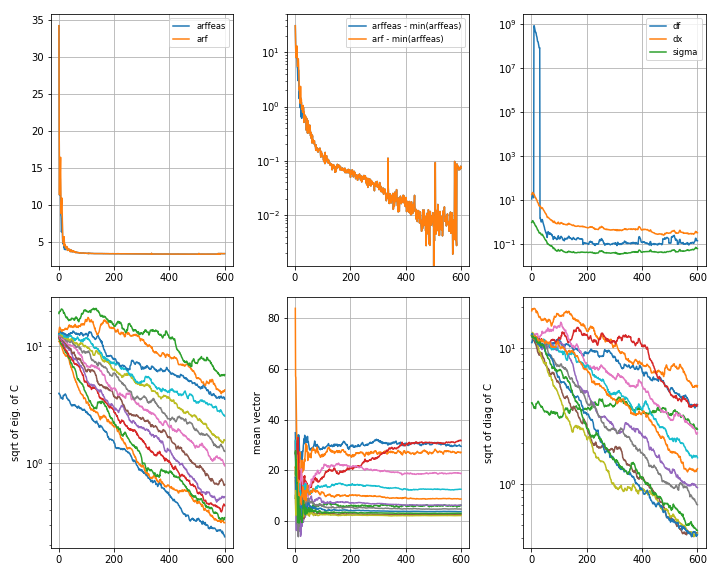

In [4]:
from IPython.display import Image
Image(filename=('OutputCmaes.png'))

# アニメーション作成用スクリプト
flg_visualizatione = T として実行した場合，VisualizeCmaes.txtが生成される．以下を実行することで，アニメーションが作成される．ffmpegがインストールされている環境であれば，mp4形式でアニメーションを保存することも可能．

#### 実行時のCMA-ES設定ファイルとVisualizeCmaes.txtから必要な情報を抽出

In [ ]:
import numpy as np

def property2dict(filename):
    out = dict()
    with open(filename, "r") as f:
        lines = f.readlines()
    for line in lines:
        key_value_list = line.split()
        out[key_value_list[0]] = key_value_list[1:]
    return out

# 実行時のCMA-ES設定ファイル．必要に応じて変更
cmainit = "InitCmaes.txt"  
opts = property2dict(cmainit)
N = int(opts['dim'][0])
L = int(opts['initpopsize'][0])
flg_sep = int(opts['flag_diagonal'][0])
init_mean = np.array([float(x) for x in opts['init_mean']])
init_std = np.array([float(x) for x in opts['init_std']])
init_sigma = 1.0
init_cov = np.diag(init_std * init_std).flatten()

# arf, arffeas, arx, arxfeas, sigma, xmean, cov
# L + L + L*N + L*N + 1 + N + N*N
dat = np.loadtxt('VisualizeCmaes.txt')
nelem_cov = N if flg_sep == 1 else N * N
L = (dat.shape[1] - 1 - N - nelem_cov) // (2 + 2 * N)
if 2 * L * (1 + N) + nelem_cov + N + 1 != dat.shape[1]:
    raise ValueError("Invalid Dimension or Broken File: VisualizeCmaes.txt")
T = dat.shape[0]

#### アニメーションで用いる二次元の選択
originは原点となる座標．v1およびv2はそれぞれ図におけるx軸とy軸に対応．
図中の座標(a, b)の点は，N次元探索空間上の点 $x = origin + a \times v1 + b \times v2$ に対応．

In [ ]:
# 一次元目と二次元目をプロットする場合，以下のように設定する．
origin = np.zeros(N)
v1 = np.zeros(N) # 全て0のベクトルを作成
v2 = np.zeros(N) # 同上
v1[0] = 1.0      # v1 の先頭要素を 1 に変更 v1 = [1, 0, 0, ..., 0]
v2[1] = 1.0      # v2 の第二要素を 1 に変更 v2 = [0, 1, 0, ..., 0]

In [ ]:
# はじめの二次元を45度回転させてプロットする場合，以下のように設定する．
origin = np.zeros(N)
theta = np.pi / 4
v1 = np.zeros(N)
v2 = np.zeros(N)

v1 = [np.cos(theta), np.sin(theta)]
v2 = [-np.sin(theta), np.cos(theta)]

#### 選択した二次元に射影

In [ ]:
from cmavisualization import project_vec, project_cov, project_diagcov
# arf, arffeas, arx, arxfeas, sigma, xmean, cov
# L + L + L*N + L*N + 1 + N + N*N
arf_list = dat[:, :L]
arx_list = project_vec(dat[:, 2*L:2*L+L*N].reshape((-1, N)), origin, v1, v2).reshape((-1, 2*L))
sigma_list = dat[:, 2*L+2*L*N:2*L+2*L*N+1]
mean_list = project_vec(dat[:, 2*L+2*L*N+1:2*L+2*L*N+1+N], origin, v1, v2)
cov_list = project_diagcov(dat[:, 2*L+2*L*N+1+N:], v1, v2) if flg_sep else project_cov(dat[:, 2*L+2*L*N+1+N:], v1, v2)
init_m = project_vec([init_mean], origin, v1, v2)
init_c = project_cov([init_cov], v1, v2)
init_s = 1.0

#### 収束曲線用データ

In [ ]:
import numpy as np
dat = np.loadtxt('OutputCmaes.txt')
N = (dat.shape[1] - 6) // 3
var_dict = dict()
# 収束曲線をプロットしない場合には，以下をコメントアウト
var_dict['sigma'] = dat[:, 5]
var_dict['xmean'] = dat[:, 6 + N:6 + 2 * N]
var_dict['sqrt of eig. of C'] = dat[:, 6:6 + N]
var_dict['sqrt of diag of C'] = dat[:, 6 + 2 * N:6 + 3 * N]
# 評価値をプロットしない場合には，以下をコメントアウト
var_dict['arffeas'] = dat[:, 1]
var_dict['arf - min(arf)'] = dat[:, 2] - dat[:, 2].min()

#### 背景画像データ
バックグラウンドに画像を表示させるためには，画像を生成するためのデータを用意する．以下の例に従い，画像用データファイル名，画像データのx軸に対応する列，y軸に対応する列，および画像用の列を指定する．例えば，ファイルの構成がx, y, fなどとなっているようであれば，1, 2, 3とそれぞれ代入すればよい．以下を実行しなければ，背景画像は表示されない．

In [ ]:
from cmavisualization import extract_meshdata
imagefilename = 'mesh.txt'  # 背景画像用データ
column_list = [0, 1, 2]  # x, y, z軸用の列を選択．インデックスは0から
bg_mesh_data = extract_meshdata(imagefilename, column_list)
flg_cb = True  # カラーバーの表示

#### アニメーションインスタンスの作成

In [ ]:
# 背景画像がある場合
%matplotlib
from cmavisualization import CmaVisualization
cv = CmaVisualization(m_hist=mean_list, 
                      s_hist=sigma_list, 
                      c_hist=cov_list, 
                      init_m=init_m, 
                      init_s=init_s,
                      init_c=init_c,
                      x_hist=arx_list,
                      f_hist=arf_list,
                      bg_mesh_data=bg_mesh_data,
                      **var_dict)
cv.fig_setting(flg_cb=flg_cb, 
               xmin=bg_mesh_data[0].min(), 
               ymin=bg_mesh_data[1].min(), 
               xmax=bg_mesh_data[0].max(), 
               ymax=bg_mesh_data[1].max())

In [ ]:
# 背景画像がない場合
%matplotlib
from cmavisualization import CmaVisualization
cv = CmaVisualization(m_hist=mean_list, 
                      s_hist=sigma_list, 
                      c_hist=cov_list, 
                      init_m=init_m, 
                      init_s=init_s,
                      init_c=init_c,
                      x_hist=arx_list,
                      f_hist=arf_list,
                      **var_dict)
cv.fig_setting(flg_xhist=True)

#### 以下，繰り返し実行

In [ ]:
cv.draw(focus='off') # フォーカスを更新しない
# cv.draw(focus='on') # フォーカスを更新
# cv.draw(focus='auto') # フォーカスを自動更新

#### ffmpeg (https://www.ffmpeg.org/) がインストールされている場合には，以下で動画を保存

In [ ]:
cv.save_animation(filename='AnimationCmaes.mp4')